# <img src="https://img.icons8.com/bubbles/50/000000/mind-map.png" style="height:50px;display:inline"> ECE 046211 - Technion - Deep Learning
---

## Project
---

Install packages that are not part of the basic virtual environment defined on the ReadMe.

Import relevant packages

In [1]:
from datasets import load_dataset, Audio,DatasetDict
import numpy as np
from transformers import AutoFeatureExtractor, TrainingArguments, Trainer,AutoConfig
import evaluate
import torch
import gc
from sklearn import metrics
import matplotlib.pyplot as plt
from model.AST_FineTunedModel import AST

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get gtzan audio files and their corresponding labels from the Hugging Face Hub and split the dataset into training, validation and test sets.

In [2]:
gtzan = load_dataset("marsyas/gtzan", "all",trust_remote_code=True)
train_rest = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.2)
val_test = train_rest["test"].train_test_split(seed=42, shuffle=True, test_size=0.5)
gtzan=DatasetDict({'train': train_rest["train"],'val': val_test["train"],'test': val_test["test"]})

Get AST feature extractor which: 
1. Extracts mel-filter bank features from raw speech.
2. Pads/truncates the features to a fixed length.
3. Normalizes the features(Substracting mean and dividing by the standard deviation).

In [3]:
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

Resample the dataset according to the pretrained AST sample rate.

In [4]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

Apply AST feature extractor to the dataset. 

In [5]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
    )
    return inputs

gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)

Obtain the label mappings from the dataset.

In [6]:
id2label_fn = gtzan["train"].features["genre"].int2str
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    i: id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

Create accuracy calculation function. 

In [7]:
metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Get, adjust and train the AST pretrained model.

In [8]:
gc.collect()
torch.cuda.empty_cache()
model_config=AutoConfig.from_pretrained(model_id)
num_labels = len(id2label)
model_config.num_labels = num_labels
model_config.id2label=id2label
model_config.label2id=label2id
#No verification actions are performed on the following model hyperparametes.
model_config.to_low_rank_layer_idx=[11] #0(first layer)-11(last layer)
model_config.low_rank_layer_rank=[2] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] rank. list the same len as to_low_rank_layer.
model_config.low_rank_layer_alpha=[8] #defines to_low_rank_layer[i] with low_rank_layer_rank[i] alpha. list the same len as to_low_rank_layer.
model_config.dropout_rat=[0.05,0.1] # drop ratio of the two dropout layers in the classifier.
model_config.classifier_hidden_layer_size=100
model=AST(model_config)
#Define hyperparameters
model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 8
num_train_epochs = 70
training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
    save_total_limit=5,
    report_to='tensorboard',
)
#Train model
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"].with_format("torch"),
    eval_dataset=gtzan_encoded["val"].with_format("torch"),
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
train_results =trainer.train()
trainer.save_model('Best_Model')

c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\user\anaconda3\envs\tech046211\lib\site-packages\transformers\models\audio_spectrogram_transformer\modeling_audio_spectrogram_transformer.py:187: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(
 42%|████▏     | 5/12 [00:11<00:15,  2.18s/it]

{'loss': 2.3308, 'grad_norm': 4.081516742706299, 'learning_rate': 3.5e-05, 'epoch': 0.4}


 83%|████████▎ | 10/12 [00:22<00:04,  2.18s/it]

{'loss': 2.2739, 'grad_norm': 3.3855679035186768, 'learning_rate': 1e-05, 'epoch': 0.8}


100%|██████████| 12/12 [00:26<00:00,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}
                                               
100%|██████████| 12/12 [00:29<00:00,  2.17s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'eval_loss': 2.2423436641693115, 'eval_accuracy': 0.16, 'eval_runtime': 3.3125, 'eval_samples_per_second': 30.189, 'eval_steps_per_second': 3.925, 'epoch': 0.96}


100%|██████████| 12/12 [00:30<00:00,  2.54s/it]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024}


{'train_runtime': 30.4585, 'train_samples_per_second': 26.232, 'train_steps_per_second': 0.394, 'train_loss': 2.2941106160481772, 'epoch': 0.96}


Calculate test metrics

100%|██████████| 13/13 [00:02<00:00,  4.41it/s]


{'test_loss': 2.242910146713257, 'test_accuracy': 0.11, 'test_runtime': 3.3376, 'test_samples_per_second': 29.962, 'test_steps_per_second': 3.895}


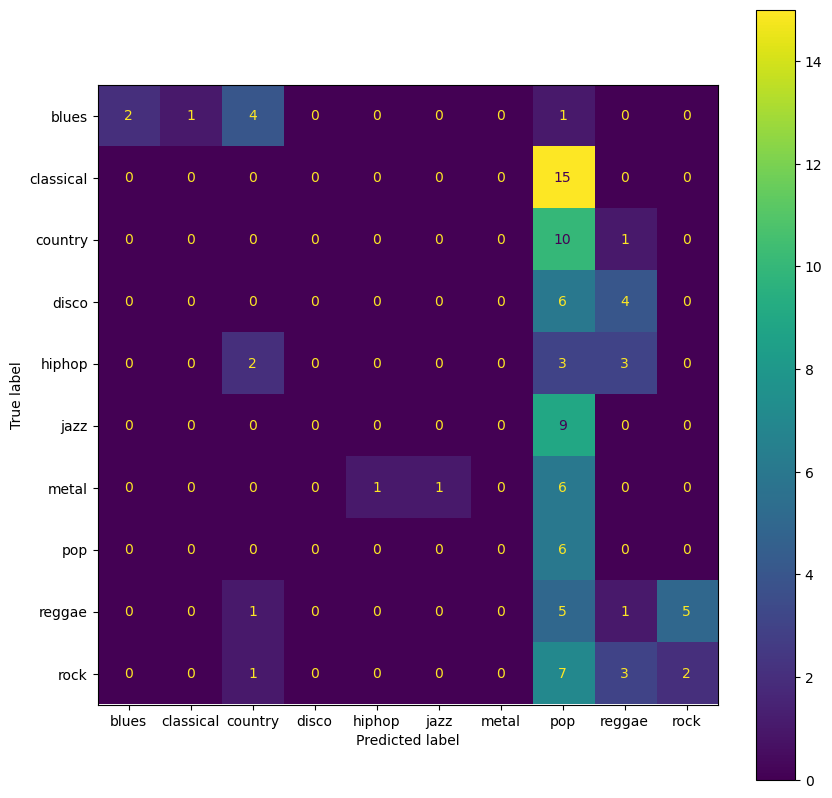

In [9]:
pred=trainer.predict(gtzan_encoded["test"].with_format("torch"))
print(pred.metrics)
confusion_matrix=metrics.confusion_matrix(pred.label_ids, np.argmax(pred.predictions, axis=1))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(label2id.keys()))
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
fig.savefig('images/Test_confusion_matrix.jpg')
plt.show()